<img src="../../docs/images/dlsia.png" width=600 />

# Latent Space Exploration with UMap and Randomized Sparse Mixed Scale Autoencoders

**Authors:** Eric Roberts and Petrus Zwart

**E-mail:** PHZwart@lbl.gov, EJRoberts@lbl.gov

This notebook highlights some basic functionality with the dlsia package.

We will setup randomly connected, sparse mixed-scale inspired autoencoders with for unsupervised learning, with the goal of exploring the latent space it generates. These autoencoders deploy random sparsely connected convolutions and random downsampling/upsampling operations (maxpooling/transposed convolutions) for compressing/expanding data in the encoder/decoder halves. This random layout supplants the structured order of typical Autoencoders, which consist downsampling/upsampling operations following dual convolutions.

Like the preceding sparse mixed-scale networks (SMSNets), there exist a number of hyperparameters to tweak so we can control the number of learnable parameters these sparsely connected networks contain. This type of control can be beneficial when the amount of data on which one can train a network is not very voluminous, as it allows for better handles on overfitting.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from dlsia.core import helpers
from dlsia.core import train_scripts
from dlsia.core.networks import sparsenet
from dlsia.test_data.two_d import random_shapes
from dlsia.core.utils import latent_space_viewer
from dlsia.viz_tools import plots, draw_sparse_network

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import einops
import umap

from IPython.display import Image

/home/ejroberts/anaconda3/envs/dlsia/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Data

Using our dlsia in-house data generator, we produce a number of noisy "shapes" images consisting of single triangles, rectangles, circles, and donuts/annuli, each assigned a different class. In addition to augmenting with random orientations and sizes, each raw, ground truth image will be bundled with its corresponding noisy and binary mask.

### Parameters to toggle:
- n_train : number of ground truth/noisy/label image bundles to generate for training
- n_test : number of ground truth/noisy/label image bundles to generate for testing
- noise_level :  per-pixel noise drawn from a continuous uniform distribution (cut-off above at 1)
- N_xy : size of individual images

In [2]:
N_train = 500
N_test  = 15000
noise_level = 0.50
Nxy = 32

train_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_train,
                                                        noise_level=noise_level,
                                                        n_xy=Nxy)
test_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_test,
                                                       noise_level=noise_level,
                                                       n_xy=Nxy)

test_GT = torch.Tensor(test_data["GroundTruth"]).unsqueeze(1)

### View shapes data

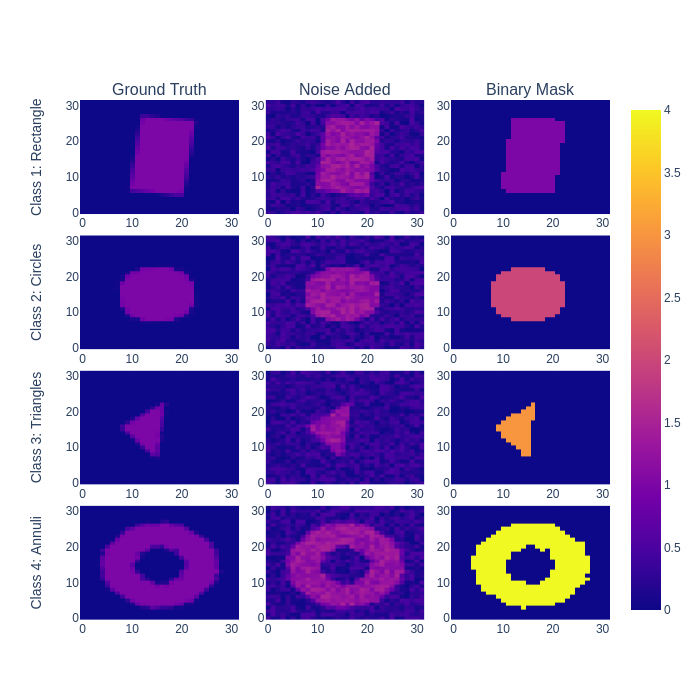

In [3]:
# normally we would use interactive plot here via
# plots.plot_shapes_data_numpy(train_data).show()
# but they don't survive when displayed in github, so
# we make it a static plot instead.
tmp = plots.plot_shapes_data_numpy(train_data)
tmp = tmp.to_image(format="png", scale=1.0)
Image(tmp)

### Dataloader class

Here we cast all images from numpy arrays and the PyTorch Dataloader class for easy handling and iterative loading of data into the networks and models. 

In [4]:
which_one = "Noisy" #"GroundTruth" 

batch_size = 100

loader_params = {'batch_size': batch_size, 
                 'shuffle': True} 
Ttrain_data = TensorDataset( torch.Tensor(train_data[which_one]).unsqueeze(1) ) 

train_loader = DataLoader(Ttrain_data, **loader_params)

loader_params = {'batch_size': batch_size, 
                 'shuffle': False} 
Ttest_data = TensorDataset( torch.Tensor(test_data[which_one][0:N_train]).unsqueeze(1) ) 
test_loader = DataLoader(Ttest_data, **loader_params)

Tdemo_data = TensorDataset( torch.Tensor(test_data[which_one]).unsqueeze(1) ) 
demo_loader = DataLoader(Tdemo_data, **loader_params)



## Build Autoencoder

There are a number of parameters to play with that impact the size of the network:

### Hyperparameters to toggle

- latent_shape: the spatial footprint of the image in latent space. I don't recommend going below 4x4, because it interferes with the  dilation choices. This is a bit of a bug, we need to fix that.  Its on the list.
- out_channels: the number of channels of the latent image. Determines the dimension of latent space: (channels,latent_shape[-2], latent_shape[-1])
- depth: the depth of the random sparse convolutional encoder / decoder
- hidden channels: The number of channels put out per convolution. 
- max_degree / min_degree : This determines how many connections you have per node.
    
    
Other parameters do not impact the size of the network dramatically / at all:

- in_shape: determined by the input shape of the image.
- dilations: the maximum dilation should not exceed the smallest image dimension.
- alpha_range: determines the type of graphs (wide vs skinny). When alpha is large,the chances for skinny graphs to be generated increases. We don't know which parameter choice is best, so we randomize it's choice.
- gamma_range: no effect unless the maximum degree and min_degree are far apart. We don't know which parameter choice is best, so we randomize it's choice.
- pIL, pLO, IO: keep as is. 
- stride_base: make sure your latent image size can be generated from the in_shape by repeated division of with this number.

In [5]:
autoencoder = sparsenet.SparseAutoEncoder(in_shape=(32, 32), 
                                          latent_shape=(4, 4), 
                                          depth=20, 
                                          dilations=[1,2,3], 
                                          hidden_channels=4, 
                                          out_channels=1, 
                                          alpha_range=(0.05, 0.25), 
                                          gamma_range=(0.0, 0.5), 
                                          max_degree=10, min_degree=4, 
                                          pIL=0.15, 
                                          pLO=0.15, 
                                          IO=False, 
                                          stride_base=2)
pytorch_total_params = helpers.count_parameters(autoencoder)
print( "Number of parameters:", pytorch_total_params)

Number of parameters: 64141


### Visualize encoder half

We visualize the layout of connections in the encoder half of the Autoencoder, the first half responsible for the lower-dimensional compression of the data in the latent space.

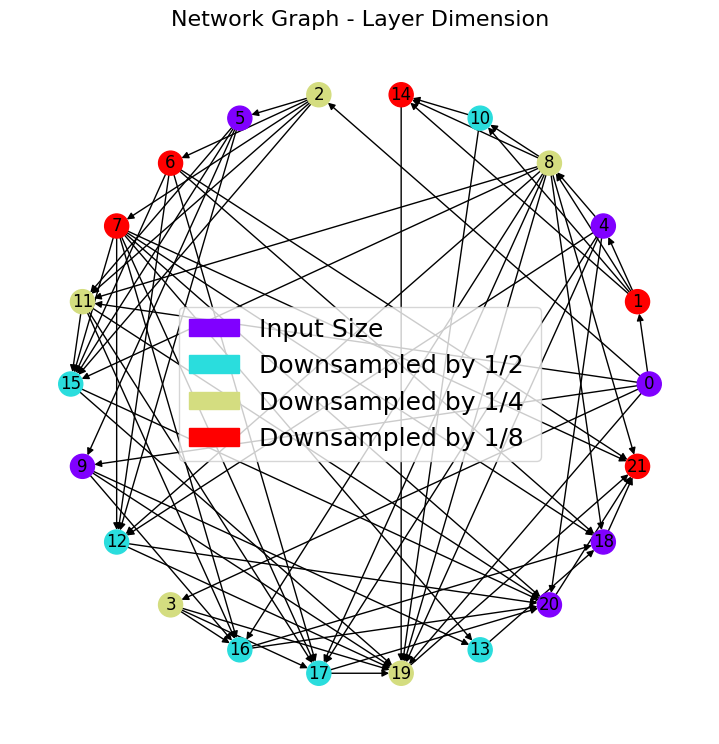

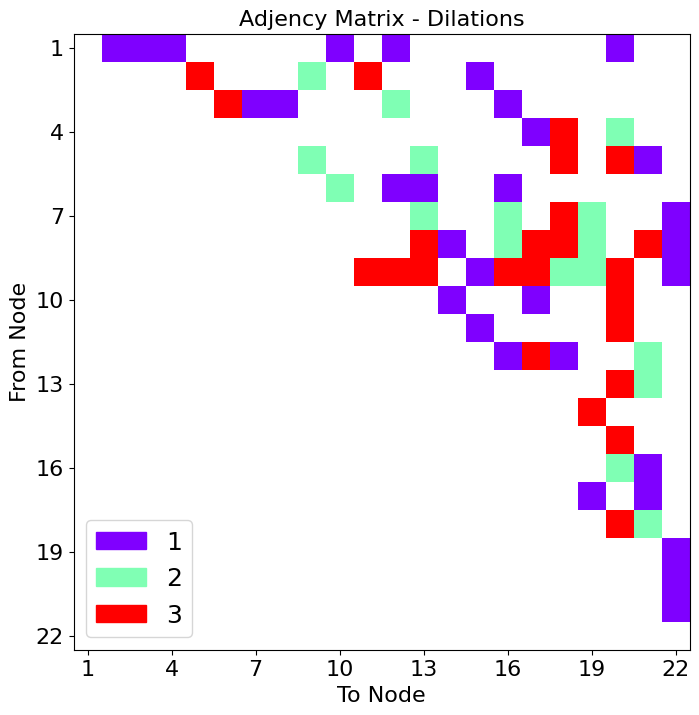

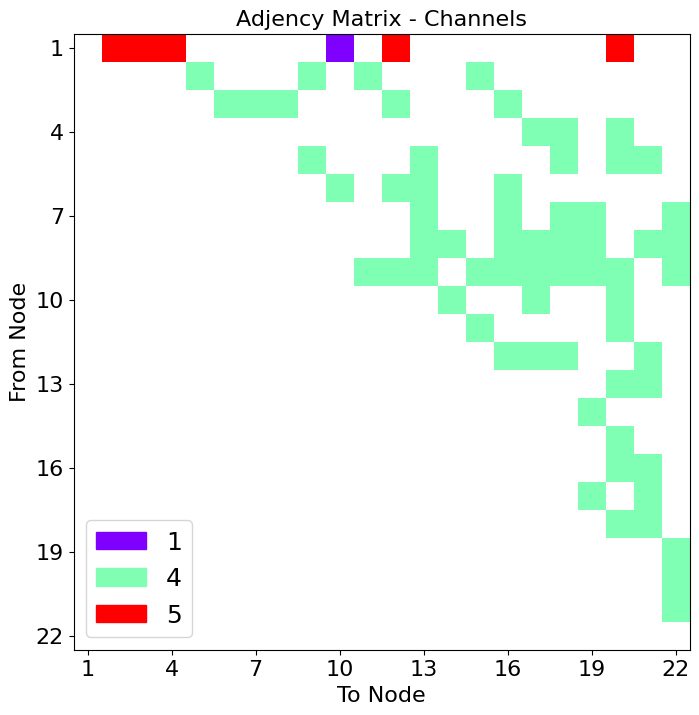

In [6]:
ne,de,ce = draw_sparse_network.draw_network(autoencoder.encode)

### Visualize decoder half

Now the visualization of connections comprising the decoder half of the Autoencoder. This second half is responsible for reconstructing the exact image input from the compressed information in the latent space

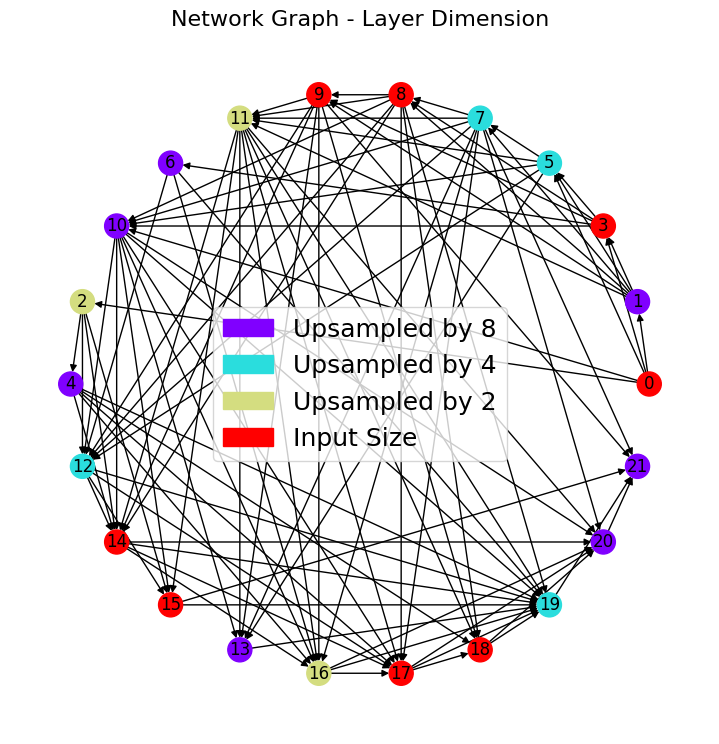

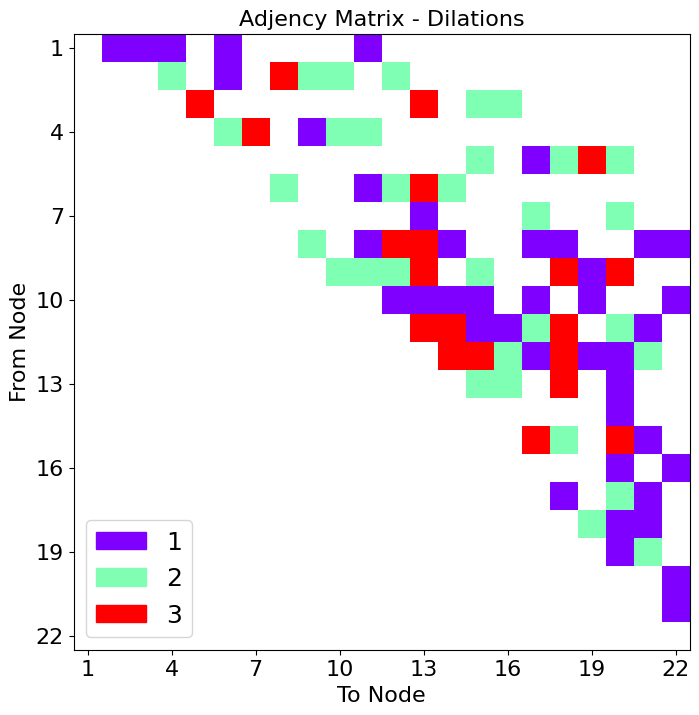

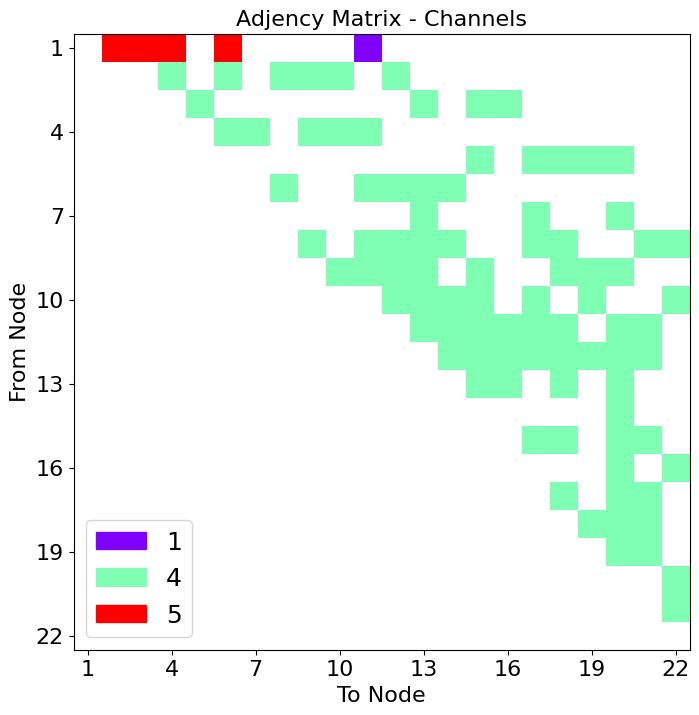

In [7]:
nd,dd,cd = draw_sparse_network.draw_network(autoencoder.decode)

## Training the Autoencoder

Training hyperparameters are specified.

In [8]:
torch.cuda.empty_cache()   # Empty superfluous information from GPU memory

learning_rate = 1e-3
num_epochs=50
criterion = nn.L1Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

### Training loop

In [9]:
torch.cuda.empty_cache()

rv = train_scripts.train_autoencoder(net=autoencoder.to('cuda:0'),
                               trainloader=train_loader,
                               validationloader=test_loader,
                               NUM_EPOCHS=num_epochs,
                               criterion=criterion,
                               optimizer=optimizer,
                               device="cuda:0", show=10)
print("Best Performance:", rv[1]["CC validation"][rv[1]['Best model index']])        

Epoch 10 of 50 | Learning rate 1.000e-03
Training Loss: 2.3064e-01 | Validation Loss: 2.2154e-01
Training CC: 0.6266   Validation CC  : 0.6508 
Epoch 20 of 50 | Learning rate 1.000e-03
Training Loss: 1.7210e-01 | Validation Loss: 1.7255e-01
Training CC: 0.8188   Validation CC  : 0.8181 
Epoch 30 of 50 | Learning rate 1.000e-03
Training Loss: 1.6213e-01 | Validation Loss: 1.6338e-01
Training CC: 0.8436   Validation CC  : 0.8416 
Epoch 40 of 50 | Learning rate 1.000e-03
Training Loss: 1.5738e-01 | Validation Loss: 1.5896e-01
Training CC: 0.8554   Validation CC  : 0.8525 
Epoch 50 of 50 | Learning rate 1.000e-03
Training Loss: 1.5510e-01 | Validation Loss: 1.5723e-01
Training CC: 0.8609   Validation CC  : 0.8567 
Best Performance: 0.8572660923004151


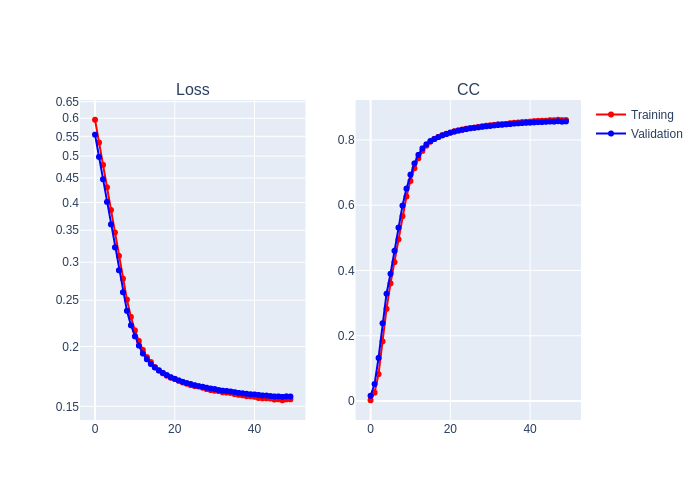

In [10]:
# normally we would use interactive plot here,
# but they don't survive when displayed in github, so
# we make it a static plot instead.

tmp = plots.plot_training_results_regression(rv[1])
tmp = tmp.to_image(format="png", scale=1.0)
Image(tmp)

## Latent space exploration

With the full SMSNet-Autoencoder trained, we pass new testing data through the encoder-half and apply Uniform Manifold Approximation and Projection ([UMap](https://umap-learn.readthedocs.io/en/latest/)), a nonlinear dimensionality reduction technique leveraging topological structures.

### Visualize raw latent space

Test images previously unseen by the network are shown in their latent space representation.

In [11]:
results = []
latent = []
for batch in demo_loader:
    with torch.no_grad():
        res = autoencoder(batch[0].to("cuda:0"))
        lt = autoencoder.latent_vector(batch[0].to("cuda:0"))
        results.append(res.cpu())
        latent.append(lt.cpu())
results = torch.cat(results, dim=0)
latent = torch.cat(latent, dim=0)
    

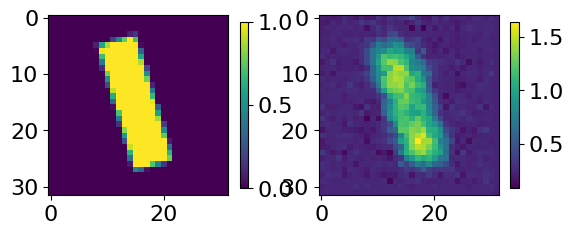

-----------------


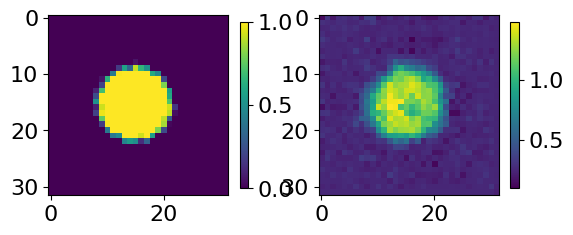

-----------------


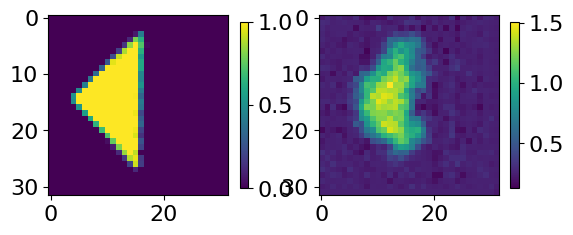

-----------------


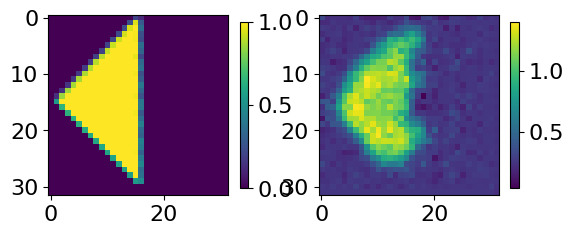

-----------------


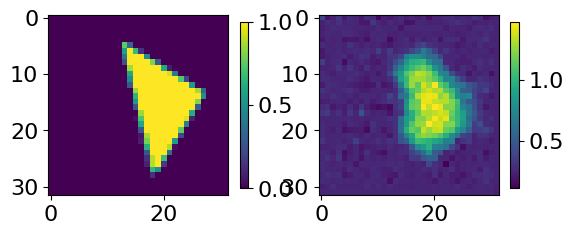

-----------------


In [12]:
for ii,jj in zip(test_GT.numpy()[0:5],results.numpy()[0:5]):
    fig, axs = plt.subplots(1,2)
    im00 = axs[0].imshow(ii[0,...])
    im01 = axs[1].imshow(jj[0])
    plt.colorbar(im00,ax=axs[0], shrink=0.45)
    plt.colorbar(im01,ax=axs[1], shrink=0.45)
    plt.show()
    print("-----------------")
        

### UMap compression

Autoencoder latent space is further reduced down to two dimensions; i.e. each image passed though the encoder is represented by an integer pair of coordinates below, with blue repesenting all rectangles, orange representing all circles/discs, green representing all triangles, and red representing all annuli.

#### UMap parameters

We outline below a few key parameters. (Further investigation into UMap capabilities can be found on [UMap documentation page](https://umap-learn.readthedocs.io/en/latest/).)

- min_dist: controls how tightly points may be packed together (default is 0.1).
- n_neighbors: controls balance of local vs. global structure in the data (default is 15).
- n_components: dimensionality of final reduction (default is 2; for 3d embedding, use n_components=3).

In [13]:
umapper = umap.UMAP(min_dist=0, n_neighbors=35)
X = umapper.fit_transform(latent.numpy())

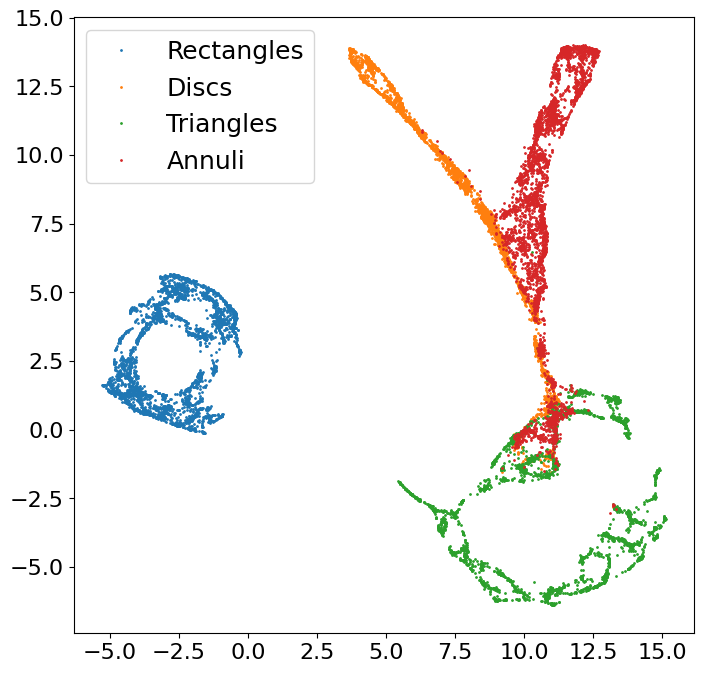

In [14]:
these_labels = test_data["Label"]
plt.figure(figsize=(8,8))
for lbl in [1,2,3,4]:
    sel = these_labels==lbl
    plt.plot(X[sel,0], X[sel,1], '.', markersize=2)
plt.legend(["Rectangles","Discs","Triangles","Annuli"])
plt.show()

Below simply averages all nearest-neighbors for visualization purposed.

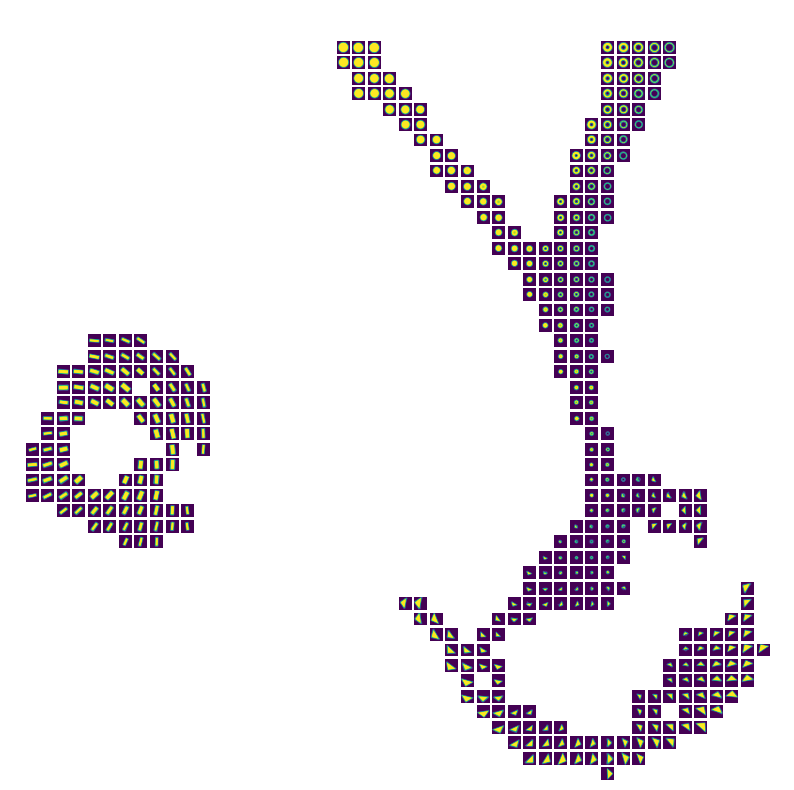

In [16]:
fig = latent_space_viewer.build_latent_space_image_viewer(test_data["GroundTruth"], 
                                                          X, 
                                                          n_bins=50, 
                                                          min_count=1, 
                                                          max_count=1, 
                                                          mode="mean"
                                                         )